In [1]:
import shutil
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


class Preprocess:

    def wholeto4Sides(self, path=None, startCoil=1, endCoil=10):
        '''rearrange the photos to 4 folders: SideA to SideD

           path: the folder path, where the whole pics to be rearranged are stored
           startCoil: the coil number rearrangement begins with
           endCoil: the coil number rearrangement ends with'''

        # define the 4 sides of a coil, which will be used as the folder names
        Side = {"1": "SideA",
                "2": "SideB",
                "3": "SideC",
                "4": "SideD"}

        for num_Coil in range(startCoil, endCoil + 1):
            CoilName = "Spule" + str(num_Coil).rjust(3, "0")
            source_folder = os.path.join(path, CoilName)

            for side in Side:
                side_folder = os.path.join(source_folder, Side[side])
                os.mkdir(side_folder)

                for num_winding in range(int(side), 961, 4):
                    src_file_name = CoilName + "_Image" + str(num_winding).rjust(4, "0") + ".jpg"
                    src_file = os.path.join(source_folder, src_file_name)
                    des_folder = os.path.join(source_folder, side_folder)
                    shutil.move(src_file, des_folder)

                    print(src_file + "=======>" + des_folder)

    def getsheets(self, path=None, num_Coil=None):
        '''extract 4 sheets of each excel file, which includes the label data of the coils
           concatenate and sort the 4 sheets by image name

           path: the folder path, where the all the raw label data are stored
           num_Coil: the coil number, of which the label data (sheets) to be extracted '''

        CoilName = "Spule" + str(num_Coil).rjust(3, "0")

        # import the 4 sheets of the excel file
        df = []
        file = CoilName + "_Labeln.xlsx"
        for num_sheet in range(4):
            side = pd.read_excel(os.path.join(path, file), num_sheet)
            df.append(side)

        # concatenate the sheets all together
        df = pd.concat(df, ignore_index=True)
        
        #drop the doubtful items, where "Doubtful" column = 1
        df = df.drop(df[df["Problem"] == 1].index)
        
        # sort the content by their image names
        df = df.sort_values(by=["Image"], ignore_index=True)
        return df

    

    def to_multilabel(self, path):
        '''generate a csv file which is suitable for multilabel model, 4 outpus:
           respectively "0_inOrdnung", "1_Deppelwindung", "2_Luecke" and "3_Kreuzung"
           path: the raw csv file'''
        
        df = pd.read_csv(path)
        
        #add 4 new columns
        df["0_inOrdnung"] = np.where(
            (df["Quality_Binary"] == 1),
            "1", "0")
        df["1_Doppelwindung"] = np.where(
            (df["Error_Multi"] == 1) | (df["Error_Multi"] == 4) | (df["Error_Multi"] == 5) | (df["Error_Multi"] == 7),
            "1", "0")
        df["2_Luecke"] = np.where(
            (df["Error_Multi"] == 2) | (df["Error_Multi"] == 4) | (df["Error_Multi"] == 6) | (df["Error_Multi"] == 7),
            "1", "0")
        df["3_Kreuzung"] = np.where(
            (df["Error_Multi"] == 3) | (df["Error_Multi"] == 5) | (df["Error_Multi"] == 6) | (df["Error_Multi"] == 7),
            "1", "0")
        #delete other columns
        new_oder = ["Image", "0_inOrdnung", "1_Doppelwindung", "2_Luecke", "3_Kreuzung"]
        df = df[new_oder]
        
        # append ".jpg" to all the filenames in the image column of the dataframe  to convert the file ids to actual filenames

        def append_ext(fn):
            return fn + ".jpg"
        
        df["Image"]=df["Image"].apply(append_ext)
        df.sort_values(by=["Image"],ignore_index=True)

        return df



In [17]:
#path = os.getcwd()
#pre = Preprocess()
#pre.wholeto4Sides(path = path, startCoil=31, endCoil=40)

In [18]:
path =os.getcwd()
path = os.path.join(path, "40_Spulen_Label_v1")
print(path)

pre = Preprocess()
res = []


for num_Coil in range(1,41):
    df = pre.getsheets(path = path, num_Coil=num_Coil)
    res.append(df)

res = pd.concat(res, ignore_index= True)
res = res.sort_values(by=["Image"],ignore_index=True)
print("the image labels of 40 Coils are:\n", res)
res
res.to_csv('40_Spulen_v1.csv', index=False)    

D:\MA_Yijie_Ma\0_Datensatz\0_Training_Datensatz\1_40_Spulen\40_Spulen_Label_v1
the image labels of 40 Coils are:
                     Image  Quality_Binary  Error_Multi Problem
0      Spule001_Image0001               0          0.0     NaN
1      Spule001_Image0002               0          0.0     NaN
2      Spule001_Image0003               0          0.0     NaN
3      Spule001_Image0004               0          0.0     NaN
4      Spule001_Image0005               0          0.0     NaN
...                   ...             ...          ...     ...
38037  Spule040_Image0956               0          0.0     NaN
38038  Spule040_Image0957               0          0.0     NaN
38039  Spule040_Image0958               0          0.0     NaN
38040  Spule040_Image0959               0          0.0     NaN
38041  Spule040_Image0960               0          0.0     NaN

[38042 rows x 4 columns]


In [20]:
path = os.getcwd()
path = os.path.join(path, "40_Spulen_v1.csv")
pre = Preprocess()
df = pre.to_multilabel(path = path)
df.to_csv("40_Spulen_MultiLabel_v1.csv", index =False)
df

,Image,0_inOrdnung,1_Doppelwindung,2_Luecke,3_Kreuzung
0,Spule001_Image0001.jpg,0,0,0,0
1,Spule001_Image0002.jpg,0,0,0,0
2,Spule001_Image0003.jpg,0,0,0,0
3,Spule001_Image0004.jpg,0,0,0,0
4,Spule001_Image0005.jpg,0,0,0,0
...,...,...,...,...,...
38037,Spule040_Image0956.jpg,0,0,0,0
38038,Spule040_Image0957.jpg,0,0,0,0
38039,Spule040_Image0958.jpg,0,0,0,0
38040,Spule040_Image0959.jpg,0,0,0,0


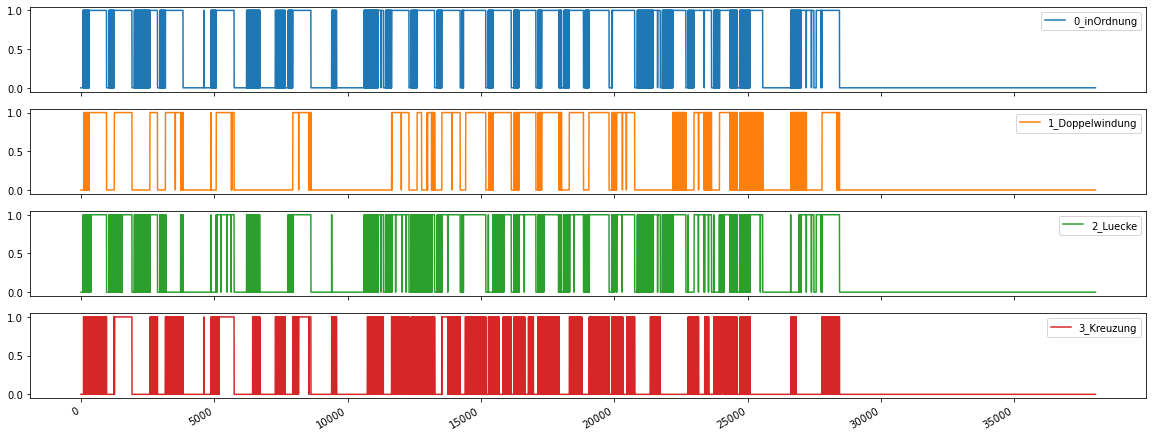

In [21]:
# visualize the training data set

df = pd.read_csv("40_Spulen_MultiLabel_v1.csv")

# derive a column "0_inOrdnung" from other 3 columns, when other 3 columns are 0, is "0_Ordnung" also 0
#df["0_inOrdnung"] = np.where(
            #(df["1_Doppelwindung"] == 1) | (df["2_Luecke"] == 1) | (df["3_Kreuzung"] == 1),
            #"1", "0")
df1 = df[["0_inOrdnung","1_Doppelwindung","2_Luecke","3_Kreuzung"]].astype(float)
#df1.to_csv("40_Spulen_MultiLabel_4outputs.csv", index =False)


df1.plot(subplots = True,figsize = (20,8))


plt.show()

In [7]:
df2 = pd.read_csv("40_Spulen_MultiLabel.csv")

# derive a column "0_inOrdnung" from other 3 columns, when other 3 columns are 0, is "0_Ordnung" also 0
df2["0_inOrdnung"] = np.where(
            (df["1_Doppelwindung"] == 1) | (df["2_Luecke"] == 1) | (df["3_Kreuzung"] == 1),
            "1", "0")
df2 = df[["Image","0_inOrdnung","1_Doppelwindung","2_Luecke","3_Kreuzung"]]
df2.to_csv("40_Spulen_MultiLabel_4outputs.csv", index =False)
df2

,Image,0_inOrdnung,1_Doppelwindung,2_Luecke,3_Kreuzung
0,Spule001_Image0001.jpg,0,0,0,0
1,Spule001_Image0002.jpg,0,0,0,0
2,Spule001_Image0003.jpg,0,0,0,0
3,Spule001_Image0004.jpg,0,0,0,0
4,Spule001_Image0005.jpg,0,0,0,0
...,...,...,...,...,...
38395,Spule040_Image0956.jpg,0,0,0,0
38396,Spule040_Image0957.jpg,0,0,0,0
38397,Spule040_Image0958.jpg,0,0,0,0
38398,Spule040_Image0959.jpg,0,0,0,0


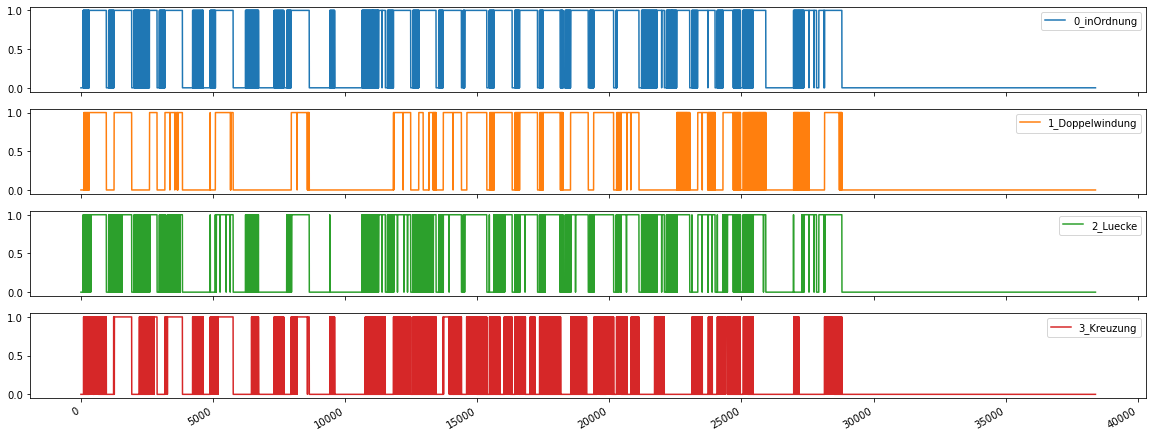

,0_inOrdnung,1_Doppelwindung,2_Luecke,3_Kreuzung
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
38395,0.0,0.0,0.0,0.0
38396,0.0,0.0,0.0,0.0
38397,0.0,0.0,0.0,0.0
38398,0.0,0.0,0.0,0.0


In [13]:
# visualize the training data set with 4 outputs


#from sklearn.utils import shuffle


df = pd.read_csv("40_Spulen_MultiLabel_4outputs.csv")


df1 = df[["0_inOrdnung","1_Doppelwindung","2_Luecke","3_Kreuzung"]].astype(float)

#df1 = shuffle(df1).reset_index(drop = True)
df1.plot(subplots = True,figsize = (20,8))
plt.show()

df1

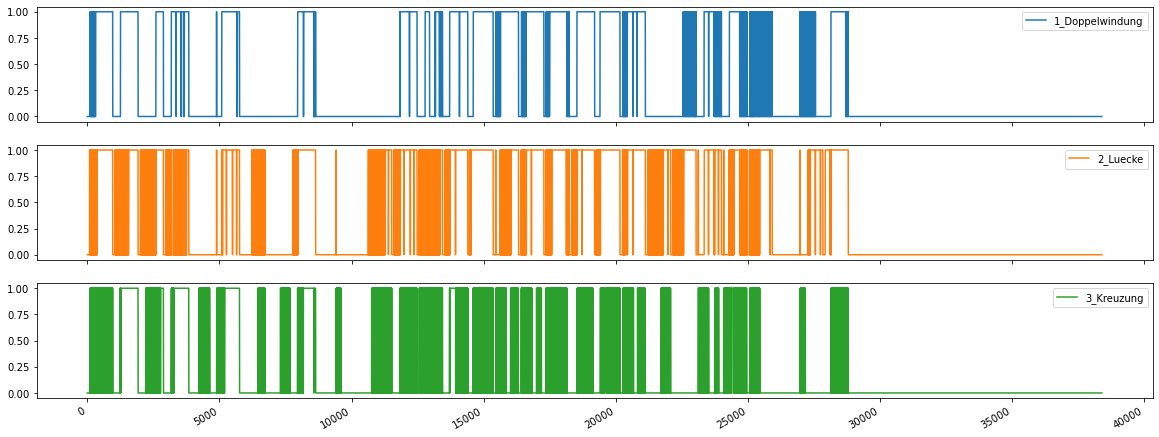

,1_Doppelwindung,2_Luecke,3_Kreuzung
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
38395,0.0,0.0,0.0
38396,0.0,0.0,0.0
38397,0.0,0.0,0.0
38398,0.0,0.0,0.0


In [2]:
### visualize the data with 3 outputs
df = pd.read_csv("40_Spulen_MultiLabel_v1.csv")


df1 = df[["0_inOrdnung","1_Doppelwindung","2_Luecke","3_Kreuzung"]]

#df1 = shuffle(df1).reset_index(drop = True)
df1.plot(subplots = True,figsize = (20,8))
plt.show()

df1

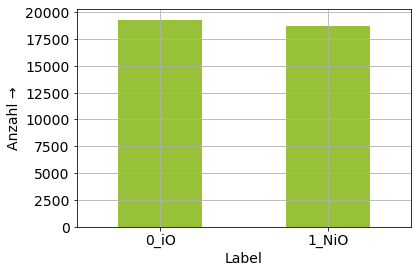

In [172]:
### binary Classfication data summary
df = pd.read_csv("40_Spulen_v1.csv")
ax = df["Quality_Binary"].value_counts().plot.bar(grid = True, table = False, fontsize = 14, color = ("#97C139"))
ax.set_xlabel("Label", fontsize = 14)
ax.set_ylabel("Anzahl →", fontsize = 14)

ax.set_xticklabels(["0_iO", "1_NiO"], rotation = 0)
plt.savefig("binaryClassificationDataSummary.jpg", dpi = 300, bbox_inches = 'tight')
plt.show()

In [96]:
df = pd.read_csv("40_Spulen_v1.csv")
df.groupby("Error_Multi").size()

Error_Multi
0.0    19212
1.0      640
2.0     4128
3.0      736
4.0     6018
5.0      811
6.0      668
7.0     5737
dtype: int64

0.0    19212
4.0     6018
7.0     5737
2.0     4128
5.0      811
3.0      736
6.0      668
1.0      640
Name: Error_Multi, dtype: int64


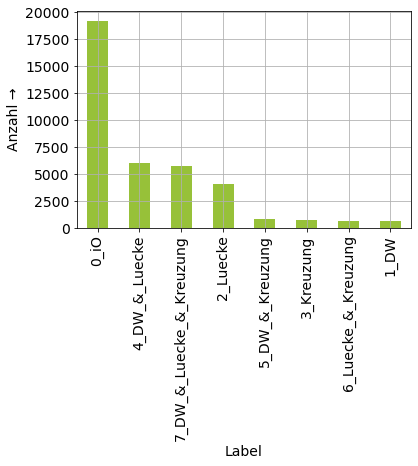

In [173]:
### Mulriclass Classfication data summary
df = pd.read_csv("40_Spulen_v1.csv")
ax = df["Error_Multi"].value_counts(sort = True)
print(ax)
ax = ax.plot.bar(grid = True,  fontsize = 14, color = ("#97C139"))
ax.set_xlabel("Label", fontsize = 14)
ax.set_ylabel("Anzahl →", fontsize = 14)
#ax.set_xticklabels(["0_iO", "1_DW", "2_Luecke", "3_Kreuzung", "4_DW_&_Luecke", "5_DW_&_Kreuzung", "6_Luecke_&_Kreuzung", "7_DW_&_Luecke_&_Kreuzung"], rotation = 45)
ax.set_xticklabels(["0_iO", "4_DW_&_Luecke", "7_DW_&_Luecke_&_Kreuzung", "2_Luecke", "5_DW_&_Kreuzung", "3_Kreuzung",   "6_Luecke_&_Kreuzung", "1_DW"], rotation = 90)
plt.savefig("multiClassificationDataSummary.jpg", dpi = 300, bbox_inches = 'tight')
plt.show()

                     0      1
0_inOrdnung      19304  18738
1_Doppelwindung  24836  13206
2_Luecke         21491  16551
3_Kreuzung       30090   7952


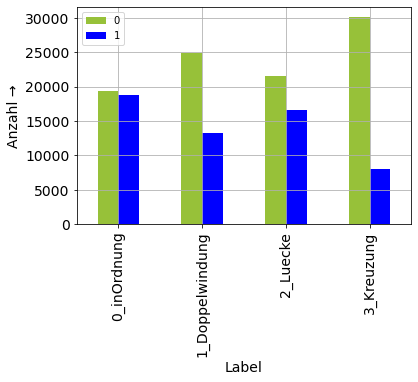

In [176]:
### Multilabel Classfication data summary
df = pd.read_csv("40_Spulen_MultiLabel_v1.csv")
df1 = df[["0_inOrdnung"]].value_counts()
df2 = df[["1_Doppelwindung"]].value_counts()
df3 = df[[ "2_Luecke"]].value_counts()
df4 = df[["3_Kreuzung"]].value_counts()

ax = pd.DataFrame(list(zip(df1,df2,df3,df4)))
ax = ax.rename(columns = {0:'0_inOrdnung', 1:"1_Doppelwindung", 2:"2_Luecke", 3:"3_Kreuzung"}).T
print(ax)
ax = ax.plot( kind = "bar", grid = True, fontsize = 14, color = [("#97C139"), "b"])
ax.set_xlabel("Label", fontsize = 14)
ax.set_ylabel("Anzahl →", fontsize = 14)
plt.savefig("multiLabelificationDataSummary.jpg", dpi = 300, bbox_inches = 'tight')
plt.show()